In [2]:
import h5py
import numpy as np
import math
import glob

In [3]:
filenames =[
"./C1_R1v2_ID1v2.mp4.predictions.000_C1_R1v2_ID1v2.analysis_fixed.h5",
"./C1_R1v4_ID1v3.mp4.predictions.000_C1_R1v4_ID1v3.analysis_fixed.h5",
"./C2_R1v2_ID1v3.mp4.predictions.000_C2_R1v2_ID1v3.analysis_fixed.h5",
"./C2_R4v1_ID4v1.mp4.predictions.000_C2_R4v1_ID4v1.analysis_fixed.h5",
"./C3_R2v1_ID3v4.mp4.predictions.000_C3_R2v1_ID3v4.analysis_fixed.h5",
"./C3_R1v4_ID4v1.mp4.predictions.000_C3_R1v4_ID4v1.analysis_fixed.h5",
'./C4_R2v1_ID3v2.mp4.predictions.000_C4_R2v1_ID3v2.analysis_fixed.h5',
"./C4_R1v4_ID2v4.mp4.predictions.000_C4_R1v4_ID2v4.analysis_fixed.h5",
"./C5_R2v1_ID2v4.mp4.predictions.000_C5_R2v1_ID2v4.analysis_fixed.h5",
"./C5_R4v1_ID3v4.mp4.predictions.000_C5_R4v1_ID3v4.analysis_fixed.h5",
"./C6_R1v2_ID1v3.mp4.predictions.slp.000_C6_R1v2_ID1v3.analysis_fixed.h5",
"./C6_R4v1_ID4v1.mp4.predictions.000_C6_R4v1_ID4v1.analysis_fixed.h5"
]

def get_info(filename):
    with h5py.File(filename, "r") as f:
        dset_names = list(f.keys())
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
    return dset_names, locations, node_names

In [4]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [5]:
def get_mouse_sides(locations):
    '''
    takes in locations
    returns (left mouse index, right mouse index)
    '''
    if locations[0,1,0,0] > locations[0,1,0,1]:
        #if mouse 0 has a greater starting x value for its nose, then it is the right mouse
        return (1, 0)
    else:
        return (0, 1)

In [6]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

In [7]:
def smooth_diff_one_dim(node_loc, win=25, poly=3):
    """
    node_loc is a [frames] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    node_loc_vel[:] = savgol_filter(node_loc[:], win, poly, deriv=1)
    

    return node_loc_vel

In [8]:
def get_distances_between_mice(locations, node_index):
    #confirmed does what i want it to
    """
    takes in locations and node index 
    returns a list of distances between the nodes of the two mice
    """
    c_list = []
    left_mouse, right_mouse = get_mouse_sides(locations)
    for i in range(len(locations)):
    
        (x1,y1) = (locations[i,node_index,0,left_mouse], locations[i,node_index,1,left_mouse])
        # x , y coordinate of nose for mouse 1
        (x2, y2) = (locations[i,node_index,0,right_mouse], locations[i,node_index,1,right_mouse])
        # x and y coordinate of nose of mouse 2
        # solve for c using pythagroean theory
        a2 = (x1 - x2) ** 2 
        b2 = (y1 - y2) ** 2 
        c = math.sqrt(a2 + b2)
        if x1 > x2:
            c_list.append(-1*c)
        else:
            c_list.append(c)
    return c_list



In [9]:
def get_distances_between_nodes(locations, node_index1, node_index2):
    # CONFIRMED THAT IT WORKS in terms of doing the math by hand
    """
    takes in locations and node indexes of the two body parts you want 
    within mice distances for 

    returns nested lists, list[0] is the distances within track1
    list[1] is the distances within track2

    """
    c_list = []
    m1_c_list = []
    m2_c_list = []
    left_mouse, right_mouse = get_mouse_sides(locations)
    for i in range(len(locations)):
        x1,y1 = locations[i, node_index1,0,0], locations[i,node_index1,1,left_mouse]
        # x , y coordinate of node 1 for mouse 1
        x2,y2 = locations[i,node_index2,0,0], locations[i,node_index2,1,left_mouse]
        # x, y coordiantes of node 2 for mouse 1
        x3, y3 = locations[i,node_index1,0,1], locations[i,node_index1,1,right_mouse]
        # x and y coordinate of node 1 of mouse 2
        x4, y4 = locations[i,node_index2,0,1], locations[i,node_index2,1,right_mouse]
        # solve for c using pythagroean theory
        a2 = (x1 - x2) ** 2 
        b2 = (y1 - y2) ** 2
        a2_m2 = (x3 -x4) ** 2
        b2_m2 = (y3 - y4) ** 2 
        c2 = math.sqrt(a2_m2 + b2_m2)
        c1 = math.sqrt(a2 + b2)
        m1_c_list.append(c1)
        m2_c_list.append(c2)
    c_list.append(m1_c_list)
    c_list.append(m2_c_list)
    return c_list

In [10]:
def get_speeds(locations, node_index):

    node_loc_1 = locations[:,node_index,:,0]
    # node loc (x,y) of node of mouse 1
    node_loc_2 = locations[:,node_index,:,1]
    # x,y's of node of mouse 2 
    m1_vel = smooth_diff(node_loc_1)
    m2_vel = smooth_diff(node_loc_2)
    velocities = [m1_vel,m2_vel]
    return velocities 

In [11]:
def get_velocities(locations, node_index):

    left_mouse, right_mouse = get_mouse_sides(locations)
    node_loc_left = locations[:,node_index, 0,left_mouse]
    # node loc (x,y) of node of mouse 1
    node_loc_right = (locations[:,node_index, 0,right_mouse]) * (-1)
    # x,y's of node of mouse 2 
    
    m1_vel = smooth_diff_one_dim(node_loc_left)
    m2_vel = smooth_diff_one_dim(node_loc_right)
    velocities = [m1_vel,m2_vel]
    return velocities 

In [12]:
def get_angles(locations, node_index_1, node_index_2, node_index_3):
    """
    takes in locations and three nodes, calculates angle between the three points 
    with the second node being the center point
    i.e. node_1 = nose , node_2 = ear , node_3 = thorax
    returns [[list of angles for mouse 1][list of angles for mouse 2]]
    """
    angles_all_mice = []
    frame, nodes, axes, mice = locations.shape
    
        
    for mouse in range(mice):
        angles = []
        for i in range(len(locations)):
            a = np.array([locations[i,node_index_1,0,mouse], locations[i,node_index_1, 1, mouse]])
            b = np.array([locations[i,node_index_2,0,mouse], locations[i,node_index_2, 1, mouse]])
            c = np.array([locations[i,node_index_3,0,mouse], locations[i,node_index_3, 1, mouse]])
            ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
            if ang < 0:
                angles.append(ang + 360)
            else: 
                angles.append(ang)
        angles_all_mice.append(angles)
    return angles_all_mice




In [13]:
videos = []
for filename in glob.glob('./all_matches_videos/videos/*'):
    videos.append(filename)
print(videos)


['./all_matches_videos/videos\\CAGE1_TUBETEST_1.1v1.2.fixed.mp4', './all_matches_videos/videos\\CAGE1_TUBETEST_1.1v1.3.fixed.mp4', './all_matches_videos/videos\\CAGE1_TUBETEST_1.2v1.3.fixed.mp4', './all_matches_videos/videos\\CAGE1_TUBETEST_1.2v1.4.fixed.mp4', './all_matches_videos/videos\\CAGE1_TUBETEST_1.3v1.4.fixed.mp4', './all_matches_videos/videos\\CAGE1_TUBETEST_1.4v1.1.fixed.mp4', './all_matches_videos/videos\\CAGE2_TUBETEST_2.1v2.2.fixed.mp4', './all_matches_videos/videos\\CAGE2_TUBETEST_2.1v2.3.fixed.mp4', './all_matches_videos/videos\\CAGE2_TUBETEST_2.2v2.3.fixed.mp4', './all_matches_videos/videos\\CAGE2_TUBETEST_2.3v2.4.fixed.mp4', './all_matches_videos/videos\\CAGE2_TUBETEST_2.4v2.1.fixed.mp4', './all_matches_videos/videos\\CAGE2_TUBETEST_2.4v2.2.fixed.mp4', './all_matches_videos/videos\\CAGE3_TUBETEST_1v3.fixed.mp4', './all_matches_videos/videos\\CAGE3_TUBETEST_2v3.fixed.mp4', './all_matches_videos/videos\\CAGE3_TUBETEST_3.1v3.2.fixed.mp4', './all_matches_videos/videos\\CA

In [14]:

loc = []
framedic = {}

is_first = True
vid = 0
for filename in glob.glob(f'./all_matches_videos/*.h5'): 
    dset_names, locations, node_names = get_info(filename)
    features = np.zeros((7,len(locations)))
    locations = fill_missing(locations)
    loc.append(len(locations))
    angles = get_angles(locations, 0, 1, 3)
    features[0] = angles[0]
    features[1] = angles[1]
    nose_velocities = get_speeds(locations, 1)
    features[2] = nose_velocities[0]
    features[3] = nose_velocities[1]
    thorax_velocities = get_velocities(locations,3)
    features[4] = thorax_velocities[0]
    features[5] = thorax_velocities[1]
    features[6] = get_distances_between_mice(locations, 1)
    if is_first:
        features_total = features
        print(videos[vid])
        framedic[videos[vid]] = (0, len(features_total[1])) 
        is_first = False
        vid += 1
    else:
        framedic[videos[vid]] = (len(features_total[1]), len(features_total[1]) + len(features[1])) 
        features_total = np.concatenate((features_total, features),1)
        vid += 1 
    





./all_matches_videos/videos\CAGE1_TUBETEST_1.1v1.2.fixed.mp4


In [15]:
print(framedic)

{'./all_matches_videos/videos\\CAGE1_TUBETEST_1.1v1.2.fixed.mp4': (0, 606), './all_matches_videos/videos\\CAGE1_TUBETEST_1.1v1.3.fixed.mp4': (606, 1002), './all_matches_videos/videos\\CAGE1_TUBETEST_1.2v1.3.fixed.mp4': (1002, 1788), './all_matches_videos/videos\\CAGE1_TUBETEST_1.2v1.4.fixed.mp4': (1788, 2769), './all_matches_videos/videos\\CAGE1_TUBETEST_1.3v1.4.fixed.mp4': (2769, 3122), './all_matches_videos/videos\\CAGE1_TUBETEST_1.4v1.1.fixed.mp4': (3122, 3411), './all_matches_videos/videos\\CAGE2_TUBETEST_2.1v2.2.fixed.mp4': (3411, 3713), './all_matches_videos/videos\\CAGE2_TUBETEST_2.1v2.3.fixed.mp4': (3713, 4298), './all_matches_videos/videos\\CAGE2_TUBETEST_2.2v2.3.fixed.mp4': (4298, 5001), './all_matches_videos/videos\\CAGE2_TUBETEST_2.3v2.4.fixed.mp4': (5001, 5478), './all_matches_videos/videos\\CAGE2_TUBETEST_2.4v2.1.fixed.mp4': (5478, 5867), './all_matches_videos/videos\\CAGE2_TUBETEST_2.4v2.2.fixed.mp4': (5867, 6266), './all_matches_videos/videos\\CAGE3_TUBETEST_1v3.fixed.m

In [16]:

features_total = np.swapaxes(features_total,0,1)
features_total.shape

(13409, 7)

In [17]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from scipy.stats import linregress
from scipy.optimize import curve_fit

In [18]:

import os
import umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import sklearn.cluster as cluster

In [19]:
reducer = umap.UMAP()
# dimenionality reduction part of UMAP ( uniform manifold approximation & projection )

standard_embedding = reducer.fit_transform(features_total)


In [20]:
clusterable_embedding = umap.UMAP(
    n_neighbors= 14,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(features_total)

clusterable_embedding.shape

(13409, 2)

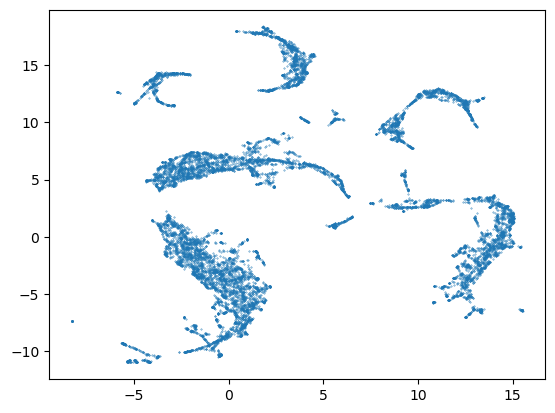

In [21]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1,)

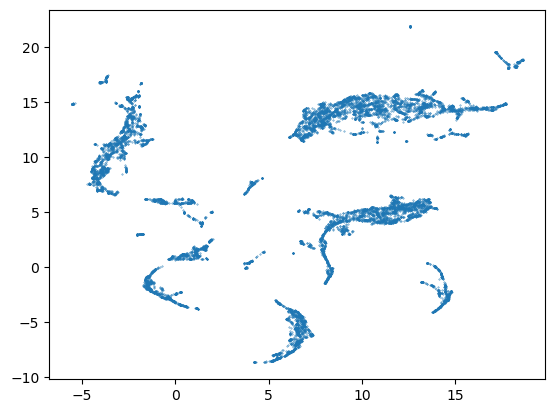

In [22]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1)

In [23]:
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(clusterable_embedding)
print(hdbscan_labels[4896])
print(hdbscan_labels[3])
print(hdbscan_labels[560])


print(np.unique(hdbscan_labels))
print(type(hdbscan_labels))
print(len(hdbscan_labels))

3
3
3
[-1  0  1  2  3  4  5  6]
<class 'numpy.ndarray'>
13409


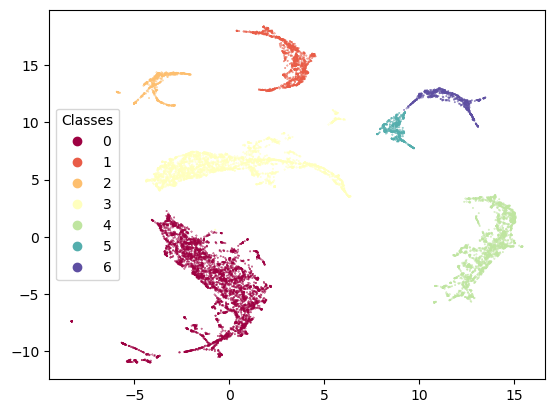

In [24]:
clustered = (hdbscan_labels >= 0)
fig, ax = plt.subplots()

# plt.scatter(standard_embedding[~clustered, 0],
#             standard_embedding[~clustered, 1],
#             color=(0.5, 0.5, 0.5),
#             s=0.1,
#             alpha=0.5)
scatter = plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral')

plt.legend(*scatter.legend_elements(),  title="Classes")
plt.savefig('./feature_clusters.png')
plt.show()


In [50]:
from moviepy.editor import *
        
    
import matplotlib as plt

In [38]:
trials = []
for item in framedic.items():
    trial = []
    start = item[1][0]
    stop = item[1][1]
    for i in range(start, stop):
        trial.append(hdbscan_labels[i])
    trials.append(trial)

        
    

In [51]:
i = 1
for trial in trials:
    plt.plot(trial, (0,len(trial))
    plt.suptitle('Trial'+ str(i))
plt.show()

SyntaxError: invalid syntax (2773813756.py, line 4)

In [28]:
def cluster_dic(labels):
    """
    takes in a list of labels (hdbscan labels)
    and returns a dictionary {cluster:[list of frames]}
    """
    clusters = {}
    print(labels)
    # if a cluster key already exists in the dictionary, append its value (list) with the new frame (i)
    for i in range(len(labels)):
        if labels[i] in clusters:
            temp_val = clusters[labels[i]]
            temp_val.append(i)
            clusters[labels[i]] = temp_val
        #if the cluser does not have a unique key yet, create one, who 
        else:
            clusters[labels[i]] = [i]
    return clusters

cluster_dict = cluster_dic(hdbscan_labels)

[3 3 3 ... 3 3 0]


In [29]:
import moviepy.editor as mpy
#create temp list of frames for the range you are on so you only have to open each video once 
def make_clip(list_of_frames, framedic):
    vid_to_frames_dict = {}
    frames = []
    # video name , value list of frame from that video in this cluster
    # string : list of integers
    for frame in list_of_frames:
        for key, value in framedic.items():
            start = value[0]
            stop = value[1]
            if frame in range(start,stop):
                if key in vid_to_frames_dict:
                    vid_to_frames_dict[key].append(frame) 
                else:
                    vid_to_frames_dict[key] = [frame]
                break
    for key in vid_to_frames_dict:                 
        vid = VideoFileClip(key)
        for frame in vid_to_frames_dict[key]:
            start_of_vid_frame = framedic[key][0]
            frames.append(vid.get_frame((frame - start_of_vid_frame)/30))
        vid.close()

    clip = mpy.ImageSequenceClip(frames, fps=30)
    return clip


cluster_0 = cluster_dict[0]
cluster_1 = cluster_dict[1]
cluster_2 = cluster_dict[2]
cluster_3 = cluster_dict[3]
cluster_4 = cluster_dict[4]
cluster_5 = cluster_dict[5]
cluster_6 = cluster_dict[6]



In [27]:
cluster_0_vid = make_clip(cluster_0, framedic)

In [28]:
cluster_0_vid.write_videofile('7feat_cluster0.mp4')

Moviepy - Building video 7feat_cluster0.mp4.
Moviepy - Writing video 7feat_cluster0.mp4



Moviepy - Done !
Moviepy - video ready 7feat_cluster0.mp4


In [29]:
cluster_0_vid.close()

In [30]:
cluster_1 = make_clip(cluster_1, framedic)

In [31]:
cluster_1.write_videofile('7feat_cluster1.mp4')

Moviepy - Building video 7feat_cluster1.mp4.
Moviepy - Writing video 7feat_cluster1.mp4



Moviepy - Done !
Moviepy - video ready 7feat_cluster1.mp4


In [32]:
cluster_1.close()

In [33]:
cluster_2_vid = make_clip(cluster_2, framedic)

In [34]:
cluster_2_vid.write_videofile('7feat_cluster2.mp4')

Moviepy - Building video 7feat_cluster2.mp4.
Moviepy - Writing video 7feat_cluster2.mp4



Moviepy - Done !
Moviepy - video ready 7feat_cluster2.mp4


In [35]:
cluster_2_vid.close()

In [36]:
cluster_3_vid = make_clip(cluster_3, framedic)

In [37]:
cluster_3_vid.write_videofile('7feat_cluster3.mp4')

Moviepy - Building video 7feat_cluster3.mp4.
Moviepy - Writing video 7feat_cluster3.mp4



Moviepy - Done !
Moviepy - video ready 7feat_cluster3.mp4


In [38]:
cluster_3_vid.close()

In [39]:
cluster_4_vid = make_clip(cluster_4, framedic)

In [40]:
cluster_4_vid.write_videofile('7feat_cluster4.mp4')

Moviepy - Building video 7feat_cluster4.mp4.
Moviepy - Writing video 7feat_cluster4.mp4



Moviepy - Done !
Moviepy - video ready 7feat_cluster4.mp4


In [41]:
cluster_4_vid.close()

In [30]:
cluster_5_vid = make_clip(cluster_5, framedic)

In [31]:
cluster_5_vid.write_videofile('7feat_cluster5.mp4')

Moviepy - Building video 7feat_cluster5.mp4.
Moviepy - Writing video 7feat_cluster5.mp4



Moviepy - Done !
Moviepy - video ready 7feat_cluster5.mp4


In [32]:
cluster_5_vid.close()

In [33]:
cluster_6_vid = make_clip(cluster_6, framedic)

In [34]:
cluster_6_vid.write_videofile('7feat_cluster6.mp4')

Moviepy - Building video 7feat_cluster6.mp4.
Moviepy - Writing video 7feat_cluster6.mp4



Moviepy - Done !
Moviepy - video ready 7feat_cluster6.mp4


In [35]:
cluster_6_vid.close()

AttributeError: 'str' object has no attribute 'any'